In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt
import os

from dice_loss import DiceLoss
import torch.optim as optim
from brain_mri_dataset import BrainMRIDatasetBuilder,BrainMRIDataset

from transforms import BrainMRITransforms

from BCEDiceLoss import BceDiceLoss

from calculate_iou import calculate_iou
from calculate_dice_score import calculate_dice_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# batch
batch_size = 16

learning_rate = 0.0003

In [4]:
data_dir = "../datasets/lgg-mri-segmentation/kaggle_3m"

builder = BrainMRIDatasetBuilder(data_dir)
df = builder.create_df()
train_df, val_df, test_df = builder.split_df(df)

transform_ = BrainMRITransforms()

train_data = BrainMRIDataset(train_df, transform = transform_ ,  mask_transform= transform_)
val_data = BrainMRIDataset(val_df, transform = transform_ ,  mask_transform= transform_)
test_data = BrainMRIDataset(test_df, transform = transform_ ,  mask_transform= transform_)

train_dataloader = DataLoader(train_data, batch_size = batch_size , shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size , shuffle = False)


In [5]:
import torch
from torch import nn
import torch.nn.functional as F

from timm.models.layers import trunc_normal_
import math
from mamba_ssm import Mamba


from pyramidal_pooling import PyramidalPoolingModule


class PVMLayer(nn.Module):
    def __init__(self, input_dim, output_dim, d_state = 16, d_conv = 4, expand = 2, pp=False):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.norm = nn.LayerNorm(input_dim)
        self.mamba = Mamba(
                d_model=input_dim//8, # Model dimension d_model
                d_state=d_state,  # SSM state expansion factor
                d_conv=d_conv,    # Local convolution width
                expand=expand,    # Block expansion factor
        )
        self.proj = nn.Linear(input_dim, output_dim)
        self.skip_scale= nn.Parameter(torch.ones(1))
        self.pp = pp
        
        if self.pp == True:
            self.ppm = PyramidalPoolingModule(input_channels=input_dim,
                                          pool_sizes=(1,2,3,6),
                                          output_channels=[input_dim//8, input_dim//4, input_dim//2, input_dim//8]) 
    
    def forward(self, x):
        if x.dtype == torch.float16:
            x = x.type(torch.float32)

        if self.pp == True:
            ## Pyramidal Pooling
            x = self.ppm(x)

        B, C = x.shape[:2]
        assert C == self.input_dim
        n_tokens = x.shape[2:].numel()
        img_dims = x.shape[2:]
        x_flat = x.reshape(B, C, n_tokens).transpose(-1, -2)
        x_norm = self.norm(x_flat)

        x1, x2, x3, x4, x5, x6, x7, x8 = torch.chunk(x_norm, 8, dim=2)
        x_mamba1 = self.mamba(x1) + self.skip_scale * x1
        x_mamba2 = self.mamba(x2) + self.skip_scale * x2
        x_mamba3 = self.mamba(x3) + self.skip_scale * x3
        x_mamba4 = self.mamba(x4) + self.skip_scale * x4
        x_mamba5 = self.mamba(x5) + self.skip_scale * x5
        x_mamba6 = self.mamba(x6) + self.skip_scale * x6
        x_mamba7 = self.mamba(x7) + self.skip_scale * x7
        x_mamba8 = self.mamba(x8) + self.skip_scale * x8
        x_mamba = torch.cat([x_mamba1, x_mamba2,x_mamba3,x_mamba4,x_mamba5,x_mamba6,x_mamba7,x_mamba8], dim=2)

        x_mamba = self.norm(x_mamba)
        x_mamba = self.proj(x_mamba)
        out = x_mamba.transpose(-1, -2).reshape(B, self.output_dim, *img_dims)
        return out



class Channel_Att_Bridge(nn.Module):
    def __init__(self, c_list, split_att='fc'):
        super().__init__()
        c_list_sum = sum(c_list) - c_list[-1]
        self.split_att = split_att
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.get_all_att = nn.Conv1d(1, 1, kernel_size=3, padding=1, bias=False)
        self.att1 = nn.Linear(c_list_sum, c_list[0]) if split_att == 'fc' else nn.Conv1d(c_list_sum, c_list[0], 1)
        self.att2 = nn.Linear(c_list_sum, c_list[1]) if split_att == 'fc' else nn.Conv1d(c_list_sum, c_list[1], 1)
        self.att3 = nn.Linear(c_list_sum, c_list[2]) if split_att == 'fc' else nn.Conv1d(c_list_sum, c_list[2], 1)
        self.att4 = nn.Linear(c_list_sum, c_list[3]) if split_att == 'fc' else nn.Conv1d(c_list_sum, c_list[3], 1)
        self.att5 = nn.Linear(c_list_sum, c_list[4]) if split_att == 'fc' else nn.Conv1d(c_list_sum, c_list[4], 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, t1, t2, t3, t4, t5):
        att = torch.cat((self.avgpool(t1), 
                         self.avgpool(t2), 
                         self.avgpool(t3), 
                         self.avgpool(t4), 
                         self.avgpool(t5)), dim=1)
        att = self.get_all_att(att.squeeze(-1).transpose(-1, -2))
        if self.split_att != 'fc':
            att = att.transpose(-1, -2)
        att1 = self.sigmoid(self.att1(att))
        att2 = self.sigmoid(self.att2(att))
        att3 = self.sigmoid(self.att3(att))
        att4 = self.sigmoid(self.att4(att))
        att5 = self.sigmoid(self.att5(att))
        if self.split_att == 'fc':
            att1 = att1.transpose(-1, -2).unsqueeze(-1).expand_as(t1)
            att2 = att2.transpose(-1, -2).unsqueeze(-1).expand_as(t2)
            att3 = att3.transpose(-1, -2).unsqueeze(-1).expand_as(t3)
            att4 = att4.transpose(-1, -2).unsqueeze(-1).expand_as(t4)
            att5 = att5.transpose(-1, -2).unsqueeze(-1).expand_as(t5)
        else:
            att1 = att1.unsqueeze(-1).expand_as(t1)
            att2 = att2.unsqueeze(-1).expand_as(t2)
            att3 = att3.unsqueeze(-1).expand_as(t3)
            att4 = att4.unsqueeze(-1).expand_as(t4)
            att5 = att5.unsqueeze(-1).expand_as(t5)
            
        return att1, att2, att3, att4, att5
    
    
class Spatial_Att_Bridge(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared_conv2d = nn.Sequential(nn.Conv2d(2, 1, 7, stride=1, padding=9, dilation=3),
                                          nn.Sigmoid())
    
    def forward(self, t1, t2, t3, t4, t5):
        t_list = [t1, t2, t3, t4, t5]
        att_list = []
        for t in t_list:
            avg_out = torch.mean(t, dim=1, keepdim=True)
            max_out, _ = torch.max(t, dim=1, keepdim=True)
            att = torch.cat([avg_out, max_out], dim=1)
            att = self.shared_conv2d(att)
            att_list.append(att)
        return att_list[0], att_list[1], att_list[2], att_list[3], att_list[4]

    
class SC_Att_Bridge(nn.Module):
    def __init__(self, c_list, split_att='fc'):
        super().__init__()
        
        self.catt = Channel_Att_Bridge(c_list, split_att=split_att)
        self.satt = Spatial_Att_Bridge()
        
    def forward(self, t1, t2, t3, t4, t5):
        r1, r2, r3, r4, r5 = t1, t2, t3, t4, t5

        satt1, satt2, satt3, satt4, satt5 = self.satt(t1, t2, t3, t4, t5)
        t1, t2, t3, t4, t5 = satt1 * t1, satt2 * t2, satt3 * t3, satt4 * t4, satt5 * t5

        r1_, r2_, r3_, r4_, r5_ = t1, t2, t3, t4, t5
        t1, t2, t3, t4, t5 = t1 + r1, t2 + r2, t3 + r3, t4 + r4, t5 + r5

        catt1, catt2, catt3, catt4, catt5 = self.catt(t1, t2, t3, t4, t5)
        t1, t2, t3, t4, t5 = catt1 * t1, catt2 * t2, catt3 * t3, catt4 * t4, catt5 * t5

        return t1 + r1_, t2 + r2_, t3 + r3_, t4 + r4_, t5 + r5_
    

class UltraLight_VM_UNet(nn.Module):
    
    def __init__(self, num_classes=1, input_channels=3, c_list=[8,16,24,32,48,64],
                split_att='fc', bridge=True):
        super().__init__()

        self.bridge = bridge
        
        self.encoder1 = nn.Sequential(
            nn.Conv2d(input_channels, c_list[0], 3, stride=1, padding=1),
        )
        self.encoder2 =nn.Sequential(
            nn.Conv2d(c_list[0], c_list[1], 3, stride=1, padding=1),
        ) 
        self.encoder3 = nn.Sequential(
            nn.Conv2d(c_list[1], c_list[2], 3, stride=1, padding=1),
        )
        self.encoder4 = nn.Sequential(
            PVMLayer(input_dim=c_list[2], output_dim=c_list[3])
        )
        self.encoder5 = nn.Sequential(
            PVMLayer(input_dim=c_list[3], output_dim=c_list[4])
        )
        self.encoder6 = nn.Sequential(
            PVMLayer(input_dim=c_list[4], output_dim=c_list[5], pp=True)
        )

        if bridge: 
            self.scab = SC_Att_Bridge(c_list, split_att)
            print('SC_Att_Bridge was used')
        
        self.decoder1 = nn.Sequential(
            PVMLayer(input_dim=c_list[5], output_dim=c_list[4])
        ) 
        self.decoder2 = nn.Sequential(
            PVMLayer(input_dim=c_list[4], output_dim=c_list[3])
        ) 
        self.decoder3 = nn.Sequential(
            PVMLayer(input_dim=c_list[3], output_dim=c_list[2])
        )  
        self.decoder4 = nn.Sequential(
            nn.Conv2d(c_list[2], c_list[1], 3, stride=1, padding=1),
        )  
        self.decoder5 = nn.Sequential(
            nn.Conv2d(c_list[1], c_list[0], 3, stride=1, padding=1),
        )  
        self.ebn1 = nn.GroupNorm(4, c_list[0])
        self.ebn2 = nn.GroupNorm(4, c_list[1])
        self.ebn3 = nn.GroupNorm(4, c_list[2])
        self.ebn4 = nn.GroupNorm(4, c_list[3])
        self.ebn5 = nn.GroupNorm(4, c_list[4])
        self.dbn1 = nn.GroupNorm(4, c_list[4])
        self.dbn2 = nn.GroupNorm(4, c_list[3])
        self.dbn3 = nn.GroupNorm(4, c_list[2])
        self.dbn4 = nn.GroupNorm(4, c_list[1])
        self.dbn5 = nn.GroupNorm(4, c_list[0])

        self.final = nn.Conv2d(c_list[0], num_classes, kernel_size=1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        
        out = F.gelu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out # b, c0, H/2, W/2

        out = F.gelu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out # b, c1, H/4, W/4 

        out = F.gelu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out # b, c2, H/8, W/8
        
        out = F.gelu(F.max_pool2d(self.ebn4(self.encoder4(out)),2,2))
        t4 = out # b, c3, H/16, W/16
        
        out = F.gelu(F.max_pool2d(self.ebn5(self.encoder5(out)),2,2))
        t5 = out # b, c4, H/32, W/32

        if self.bridge: t1, t2, t3, t4, t5 = self.scab(t1, t2, t3, t4, t5)
        
        out = F.gelu(self.encoder6(out)) # b, c5, H/32, W/32
        
        out5 = F.gelu(self.dbn1(self.decoder1(out))) # b, c4, H/32, W/32
        out5 = torch.add(out5, t5) # b, c4, H/32, W/32
        
        out4 = F.gelu(F.interpolate(self.dbn2(self.decoder2(out5)),scale_factor=(2,2),mode ='bilinear',align_corners=True)) # b, c3, H/16, W/16
        out4 = torch.add(out4, t4) # b, c3, H/16, W/16
        
        out3 = F.gelu(F.interpolate(self.dbn3(self.decoder3(out4)),scale_factor=(2,2),mode ='bilinear',align_corners=True)) # b, c2, H/8, W/8
        out3 = torch.add(out3, t3) # b, c2, H/8, W/8
        
        out2 = F.gelu(F.interpolate(self.dbn4(self.decoder4(out3)),scale_factor=(2,2),mode ='bilinear',align_corners=True)) # b, c1, H/4, W/4
        out2 = torch.add(out2, t2) # b, c1, H/4, W/4 
        
        out1 = F.gelu(F.interpolate(self.dbn5(self.decoder5(out2)),scale_factor=(2,2),mode ='bilinear',align_corners=True)) # b, c0, H/2, W/2
        out1 = torch.add(out1, t1) # b, c0, H/2, W/2
        
        out0 = F.interpolate(self.final(out1),scale_factor=(2,2),mode ='bilinear',align_corners=True) # b, num_class, H, W
        
        return torch.sigmoid(out0)



/share/jccrews/miniconda3/envs/umamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
model = nn.DataParallel(UltraLight_VM_UNet(
    num_classes=1,
    input_channels=3,
    # c_list=[8,16,24,32,48,64],
    c_list=[16,32,64,128,256,512],
    split_att='fc',
    bridge=True
)).to(device)

SC_Att_Bridge was used


In [7]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')

Total parameters: 769677
Trainable parameters: 769677


In [8]:
# Load weights for parallel training
state_dict = torch.load('modified_ultralightmunet_v6_weights.pth', map_location=device)
# Remove the 'module.' prefix from keys if present
# state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
# Load state dict
model.load_state_dict(state_dict)
model.eval()

DataParallel(
  (module): UltraLight_VM_UNet(
    (encoder1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (encoder2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (encoder3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (encoder4): Sequential(
      (0): PVMLayer(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mamba): Mamba(
          (in_proj): Linear(in_features=8, out_features=32, bias=False)
          (conv1d): Conv1d(16, 16, kernel_size=(4,), stride=(1,), padding=(3,), groups=16)
          (act): SiLU()
          (x_proj): Linear(in_features=16, out_features=33, bias=False)
          (dt_proj): Linear(in_features=1, out_features=16, bias=True)
          (out_proj): Linear(in_features=16, out_features=8, bias=False)
        )
        (proj): Linear(in_features=64, out_features=128, bias=True)

In [9]:

size_model = 0
for param in state_dict.values():
    if param.is_floating_point():
        size_model += param.numel() * torch.finfo(param.dtype).bits
    else:
        size_model += param.numel() * torch.iinfo(param.dtype).bits
print(f"model size: {size_model} / bit | {size_model / 8e6:.2f} / MB")


model size: 24629664 / bit | 3.08 / MB


In [10]:
def visualize_sample(image, pred_mask, true_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot image
    axes[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
    axes[0].set_title('Image')
    axes[0].axis('off')
    
    # Plot predicted mask
    axes[1].imshow(pred_mask.squeeze().cpu().numpy(), cmap='gray')  # Adjust vmin and vmax for your classes
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    
    # Plot true mask
    axes[2].imshow(true_mask.squeeze().cpu().numpy(), cmap='gray')  # Adjust vmin and vmax for your classes
    axes[2].set_title('True Mask')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

/share/jccrews/miniconda3/envs/umamba/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


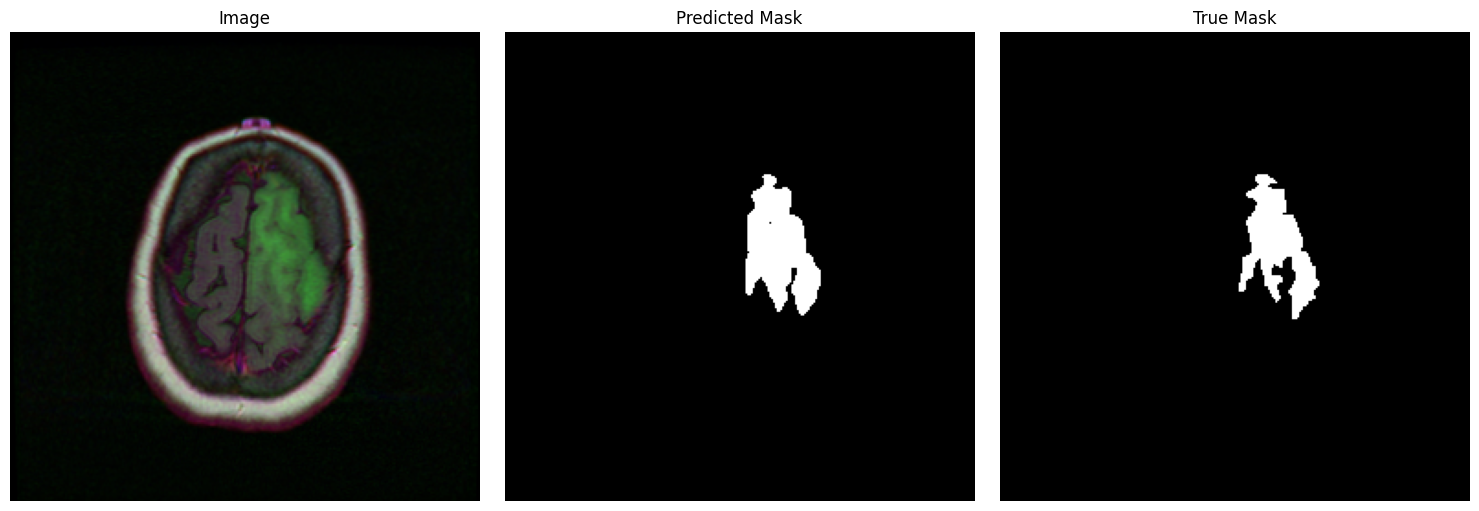

iou: 0.7625684142112732
dice: 0.8652923107147217


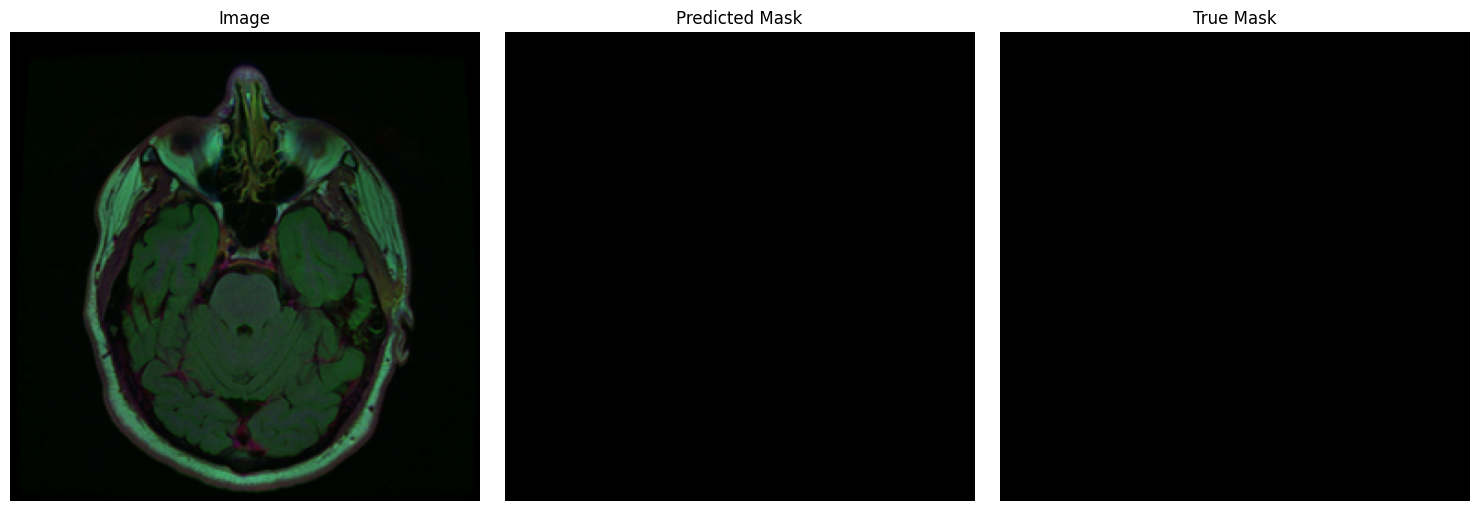

iou: 0.0
dice: nan


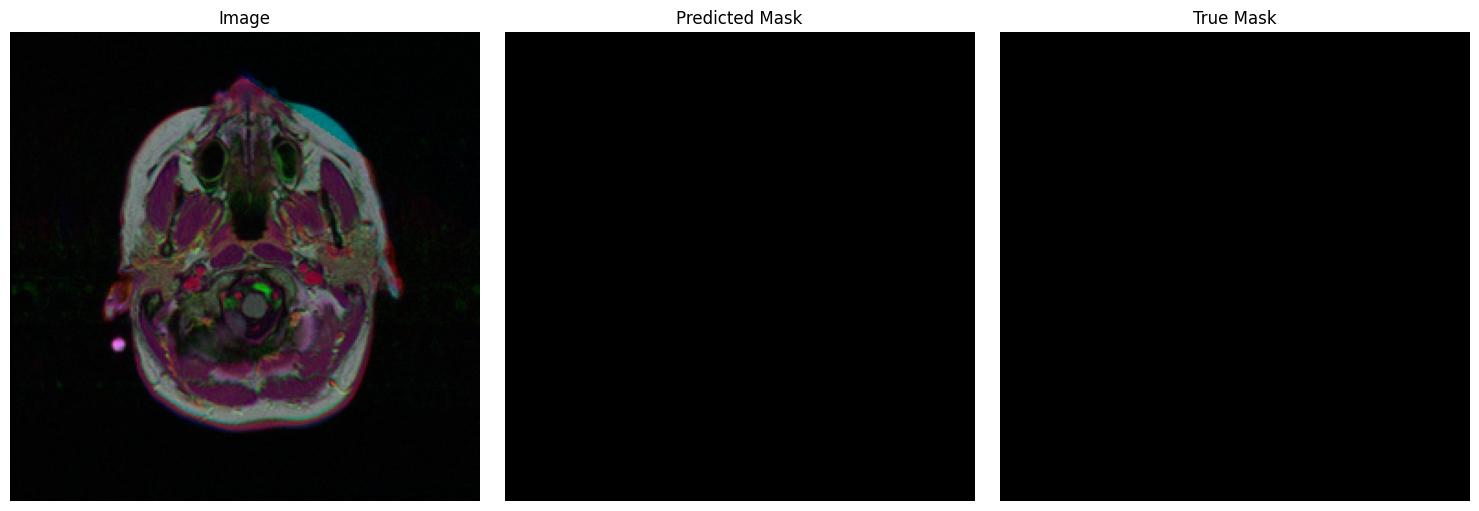

iou: 0.0
dice: nan


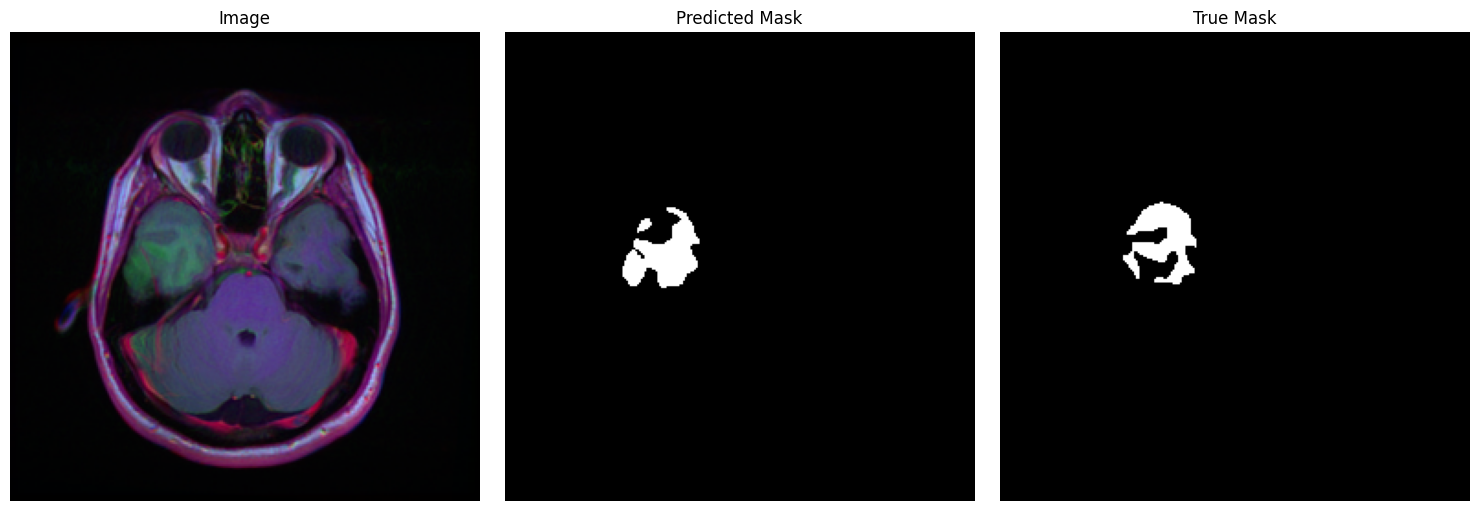

iou: 0.5015698671340942
dice: 0.6680606603622437


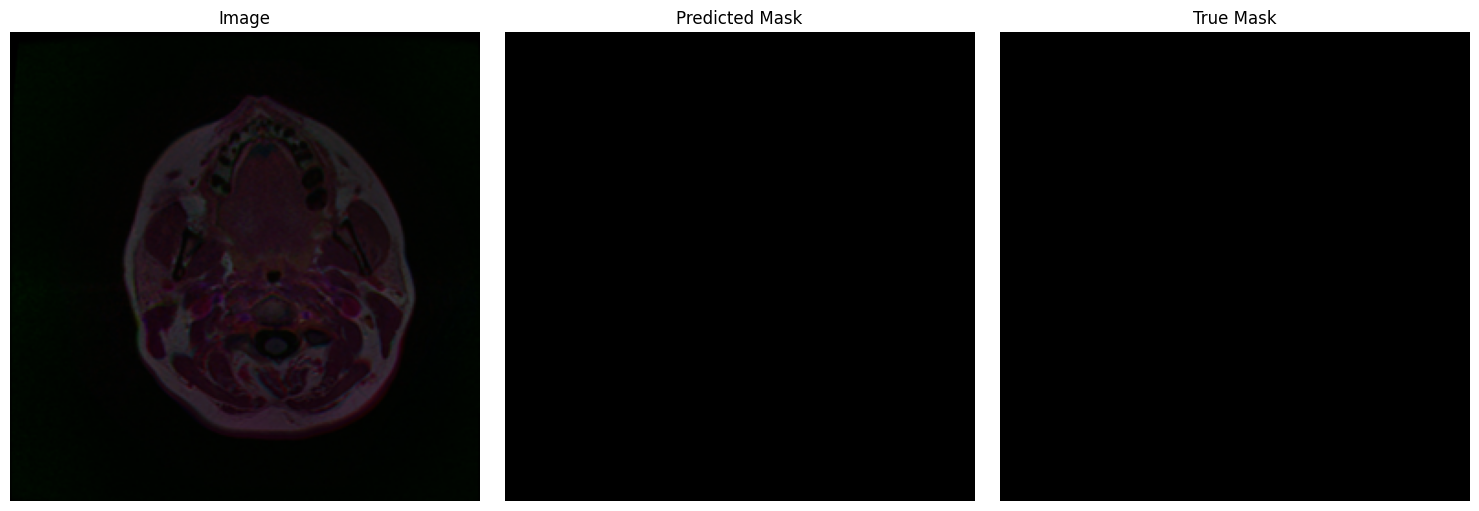

iou: 0.0
dice: nan
IOU: 0.7630167460441589
Dice: 0.862831974029541


In [11]:
total_iou = 0
total_dice_scrore = 0


with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device).float(), labels.to(device).float()

        preds = model(imgs)
        preds = torch.where(preds >= 0.5, 1., 0.)

        if (total_iou == 0):
            for k in range(5):
                visualize_sample(imgs[k], preds[k], labels[k])
                iou = calculate_iou(preds[k], labels[k])
                print(f'iou: {iou}')
                dice_score = calculate_dice_score(preds[k], labels[k])
                print(f'dice: {dice_score}')

        iou = calculate_iou(preds, labels)
        # print(f'iou: {iou}')
        total_iou += iou

        dice_score = calculate_dice_score(preds, labels)
        # print(f'dice: {dice_score}')
        total_dice_scrore += dice_score



test_iou = total_iou / len(test_dataloader)
test_dice_score = total_dice_scrore / len(test_dataloader)

print(f'IOU: {test_iou}')
print(f'Dice: {test_dice_score}')